In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.datasets import mnist

import matplotlib.pyplot as plt
import seaborn as sns

import os
os.makedirs('data', exist_ok=True)

In [2]:
SAVE_DATA = True

In [3]:
(X, y), (X_test, y_test) = mnist.load_data()

X = X.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

X = X.reshape((*X.shape, 1))
X_test = X_test.reshape((*X_test.shape, 1))

np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [4]:
# label_data = [
#     [0, 'T-shirt/top'],
#     [1, 'Trouser'],
#     [2, 'Pullover'],
#     [3, 'Dress'],
#     [4, 'Coat'],
#     [5, 'Sandal'],
#     [6, 'Shirt'],
#     [7, 'Sneaker'],
#     [8, 'Bag'],
#     [9, 'Ankle boot'],
# ]
# labels = pd.DataFrame(label_data, columns=['label','name'])
# labels.to_csv('data/label_names.csv',index=False)
# labels

In [5]:
labels = pd.DataFrame(np.arange(10).reshape(-1,1), columns=['label'])
labels['name'] = labels['label']
labels.to_csv('data/label_names.csv',index=False)
labels

,label,name
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
5,5,5
6,6,6
7,7,7
8,8,8
9,9,9


## **Visualize a Few Examples From the Dataset**

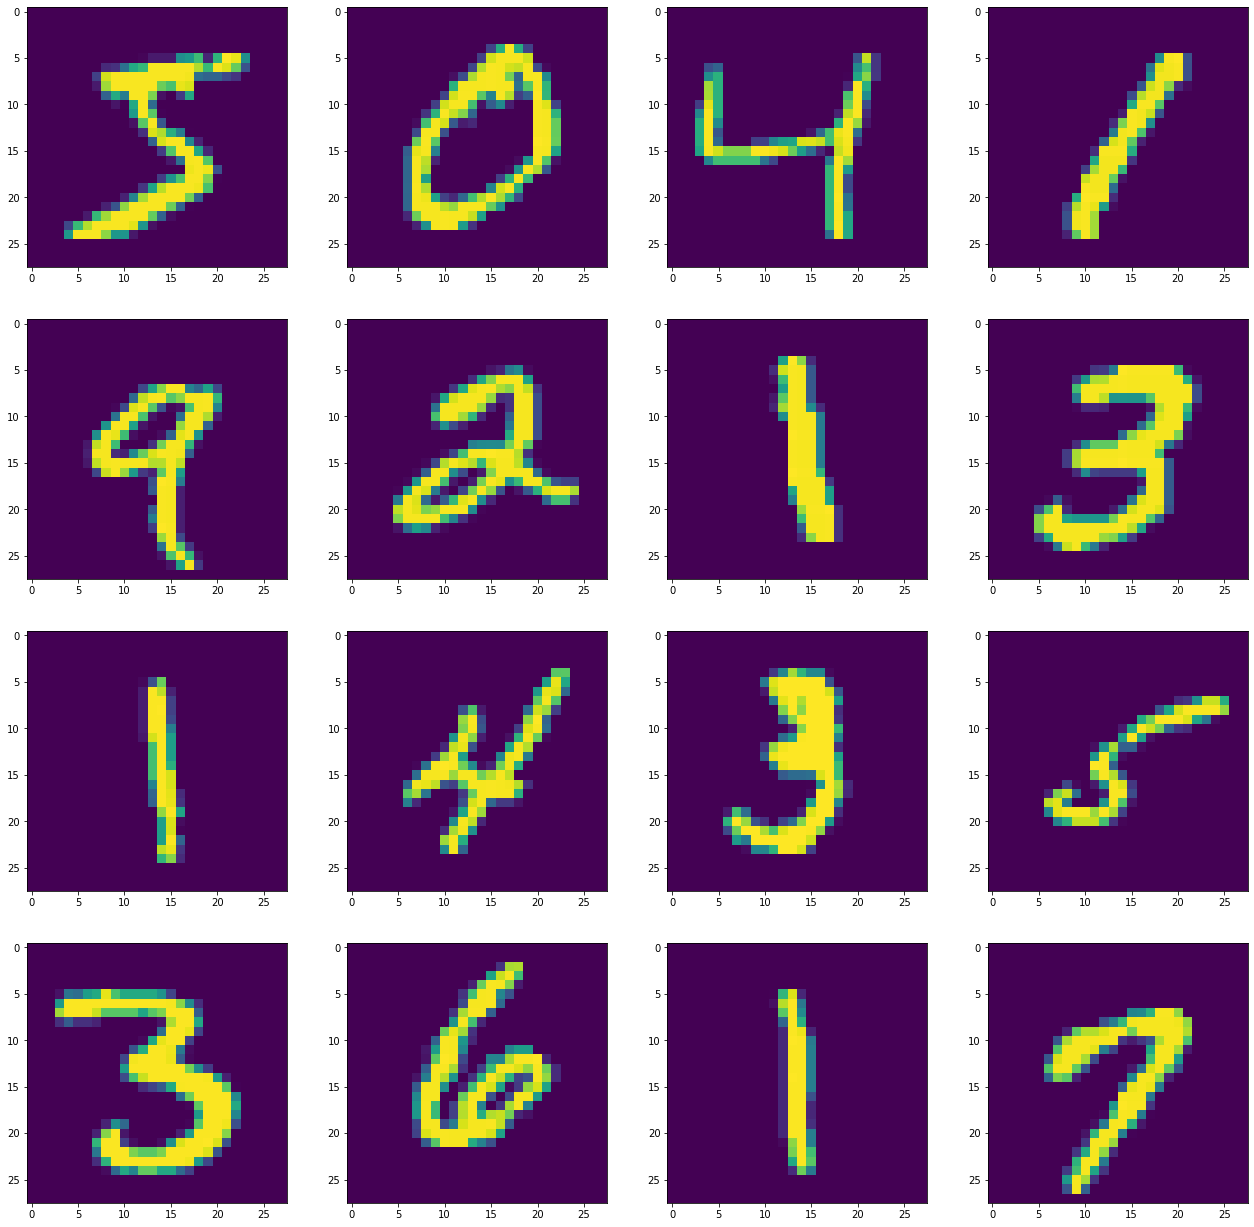

In [6]:
ROWS, COLS = 4, 4
fig, axs = plt.subplots(ROWS,COLS,figsize=(22,22))
for row in range(ROWS):
    for col in range(COLS):
        axs[row,col].imshow(X[(row*COLS)+col,:,:])

## **Build Dataset**

We are given a predefined test set, however here we will create a separated validation set for our data. This will ensure that we have a holdout set we validate on, but that will not be poisoned by training on this set of data.

In [7]:
spliter = StratifiedShuffleSplit(n_splits=1, test_size=X_test.shape[0], random_state=123)
for train_idx, test_idx in spliter.split(X, y):
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[test_idx], y[test_idx]

print(f"Train data shape: {X_train.shape} Val data shape: {X_val.shape} Test data shape: {X_test.shape}")

Train data shape: (50000, 28, 28, 1) Val data shape: (10000, 28, 28, 1) Test data shape: (10000, 28, 28, 1)


In [8]:
spliter = StratifiedShuffleSplit(n_splits=1, test_size=200, random_state=123)
for train_idx, test_idx in spliter.split(X_test, y_test):
    viz_images = X_test[test_idx]
    viz_labels = y_test[test_idx]

## **Simple EDA**

### **Subset Category Distribtions**

In [9]:
def show_category_distribution(train, val, test, subset):
    data = []
    for sub, name in zip([train, val, test],['Train','Val','Test']):
        labels, counts = np.unique(sub, return_counts=True)
        for label, count in zip(labels, counts):
            count = count / sub.shape[0]
            data.append([name, label, count])
    df = pd.DataFrame(data, columns=['Subset','Label','Fraction of Samples'])
    viz = sns.barplot(data=df, x='Label', y="Fraction of Samples", hue='Subset')
    plt.title(subset)

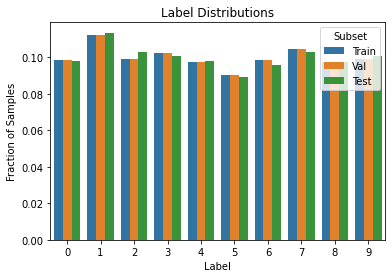

In [10]:
show_category_distribution(y_train, y_val, y_test, 'Label Distributions')

### **Image Category Tonicity by Subset**

This will help ensure that the mean and standard deviation of image tonicities between classes is similar between the train, validation, and test sets. This ensures that the data splitting has not created some arbitrary division in the style of images and that (at least from a very high level view) the training data is a good representation of all types of images we will encounter "in the wild".

In [11]:
import sys
def calculate_image_tonicity_by_category(images, labels, subset):
    categories, tonicities = [], []
    for cat in range(10):
        mask = np.where(labels==cat)[0]
        for idx in mask:
            categories.append(cat)
            tonicities.append(np.mean(images[idx, :, :, :]))
    df = pd.DataFrame({'Category': categories, 'Tonicity': tonicities, 'Subset': [subset for _ in range(len(categories))]})
    return df

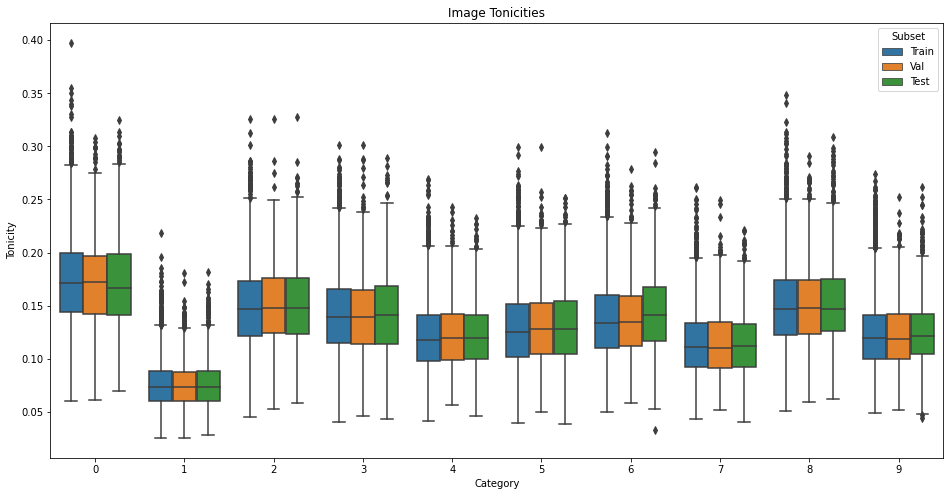

In [12]:
train_df = calculate_image_tonicity_by_category(X, y, 'Train')
val_df = calculate_image_tonicity_by_category(X_val, y_val, 'Val')
test_df = calculate_image_tonicity_by_category(X_test, y_test, 'Test')
combined_df = pd.concat([train_df, val_df, test_df])
fig, ax = plt.subplots(figsize=(16.0, 8.0))
sns.boxplot(x="Category", y="Tonicity", hue="Subset", data=combined_df, ax=ax)
plt.title("Image Tonicities");

## **Save the data to folder**

In [13]:
if(SAVE_DATA):
    with open('data/train.npy', mode='wb') as outfile:
        np.save(outfile, X_train, allow_pickle=True)
        np.save(outfile, y_train, allow_pickle=True)

    with open('data/val.npy', mode='wb') as outfile:
        np.save(outfile, X_val, allow_pickle=True)
        np.save(outfile, y_val, allow_pickle=True)

    with open('data/test.npy', mode='wb') as outfile:
        np.save(outfile, X_test, allow_pickle=True)
        np.save(outfile, y_test, allow_pickle=True)
        
    with open('data/viz.npy', mode='wb') as outfile:
        np.save(outfile, viz_images, allow_pickle=True)
        np.save(outfile, viz_labels, allow_pickle=True)        